In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from PIL import Image
import os
import numpy as np

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50 expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [8]:
train_dataset = datasets.ImageFolder('data/train', transform=transform)
val_dataset = datasets.ImageFolder('data/val', transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False
)

In [9]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False # freezes all layers, gradients wil not be calculated 

in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 2) # only this layer will be trained, automatically has requires_grad = True
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # uses Adam optimizer 

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # alows apple silicon GPU
    model = model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        # Evaluation phase
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0

        with torch.no_grad():  # No gradients needed for evaluation
            for inputs, labels in val_loader:
                inputs = inputs.to(device) # images
                labels = labels.to(device) # lables (cat/dog)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {running_loss/len(train_loader):.3f}')
        print(f'Validation Loss: {val_loss/len(val_loader):.3f}')
        print(f'Validation Accuracy: {100 * correct / total:.2f}%')
        print('-' * 60)

In [11]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10
Training Loss: 0.225
Validation Loss: 0.096
Validation Accuracy: 97.11%
------------------------------------------------------------
Epoch 2/10
Training Loss: 0.094
Validation Loss: 0.067
Validation Accuracy: 97.95%
------------------------------------------------------------
Epoch 3/10
Training Loss: 0.095
Validation Loss: 0.067
Validation Accuracy: 97.65%
------------------------------------------------------------
Epoch 4/10
Training Loss: 0.074
Validation Loss: 0.054
Validation Accuracy: 98.13%
------------------------------------------------------------
Epoch 5/10
Training Loss: 0.058
Validation Loss: 0.048
Validation Accuracy: 98.26%
------------------------------------------------------------
Epoch 6/10
Training Loss: 0.056
Validation Loss: 0.048
Validation Accuracy: 98.33%
------------------------------------------------------------
Epoch 7/10
Training Loss: 0.058
Validation Loss: 0.043
Validation Accuracy: 98.45%
-----------------------------------------------------

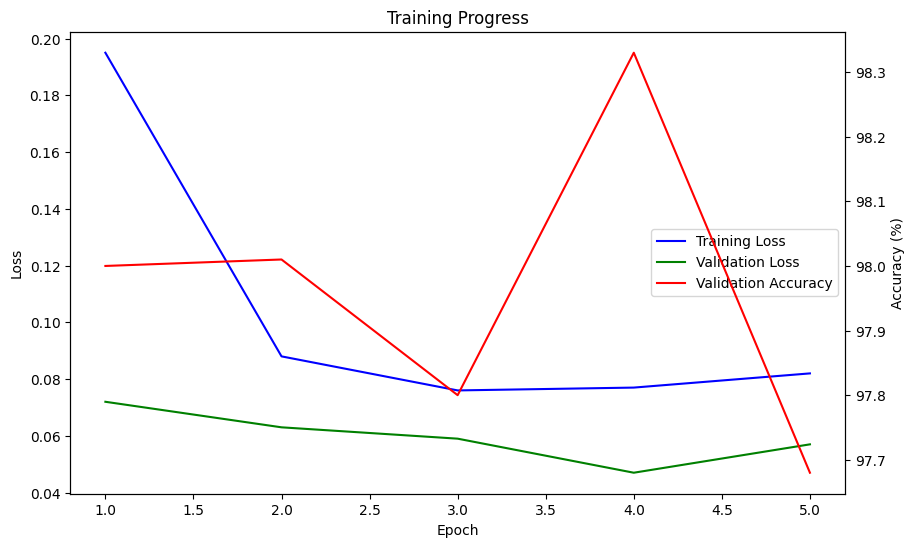

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt

# Training metrics
epochs = range(1, 6)
train_loss = [0.195, 0.088, 0.076, 0.077, 0.082]
val_loss = [0.072, 0.063, 0.059, 0.047, 0.057]
val_acc = [98.00, 98.01, 97.80, 98.33, 97.68]

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot losses on the first y-axis
ax1.plot(epochs, train_loss, 'b-', label='Training Loss')
ax1.plot(epochs, val_loss, 'g-', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot accuracy on the second y-axis
ax2.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
ax2.set_ylabel('Accuracy (%)')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.title('Training Progress')
plt.show()

# Save the plot if needed
plt.savefig('training_progress.png')